In [1]:
import numpy as np
import matplotlib.pyplot as plt

## New Keyensian

$$
\begin{align}
\hat{y}_t &=-\sigma[\hat{i}_t-E_t\{\hat{\pi}_{t+1}\}]+E_t\{\hat{y}_{t+1}\} \\
		\hat{\pi}_t&=\kappa (\hat{y}_t-\hat{y}_t^{flex}) +\beta E_t \{\hat{\pi}_{t+1}\} \\
		\hat{i}_t&=\phi_\pi\hat{\pi}_t+v_t 
\end{align}
$$
with $\hat{y}_t^{flex}=\frac{1+\varphi}{\gamma+\varphi}\hat{a}_t$.

$\beta=0.99,\sigma=1,\kappa=0.1,\rho_a=0.8,\phi_\pi=1.5, \gamma = \frac{1}{\sigma}, \varphi = 1$

## Analytical Solution

In [2]:
# Model parameters
beta = 0.99
sigma = 1
kappa = 0.1
rho_a = 0.8
phi_pi = 1.5
gamma = 1/sigma
varphi = 1

In [3]:
denominator = ((1 - rho_a) * (1 - beta * rho_a) - sigma * kappa * (rho_a - phi_pi)) * (gamma + varphi)

# Functions to compute responses
def y_hat(a_t):
    return - (sigma * kappa * (1 + varphi) * (rho_a - phi_pi) / denominator) * a_t

def pi_hat(a_t):
    return - (kappa * (1 + varphi) * (1 - rho_a) / denominator) * a_t

def i_hat(a_t):
    return phi_pi * (-kappa * (1 + varphi) * (1 - rho_a) / denominator) * a_t

def y_flex(a_t):
    return (1+varphi) / (gamma + varphi) * a_t

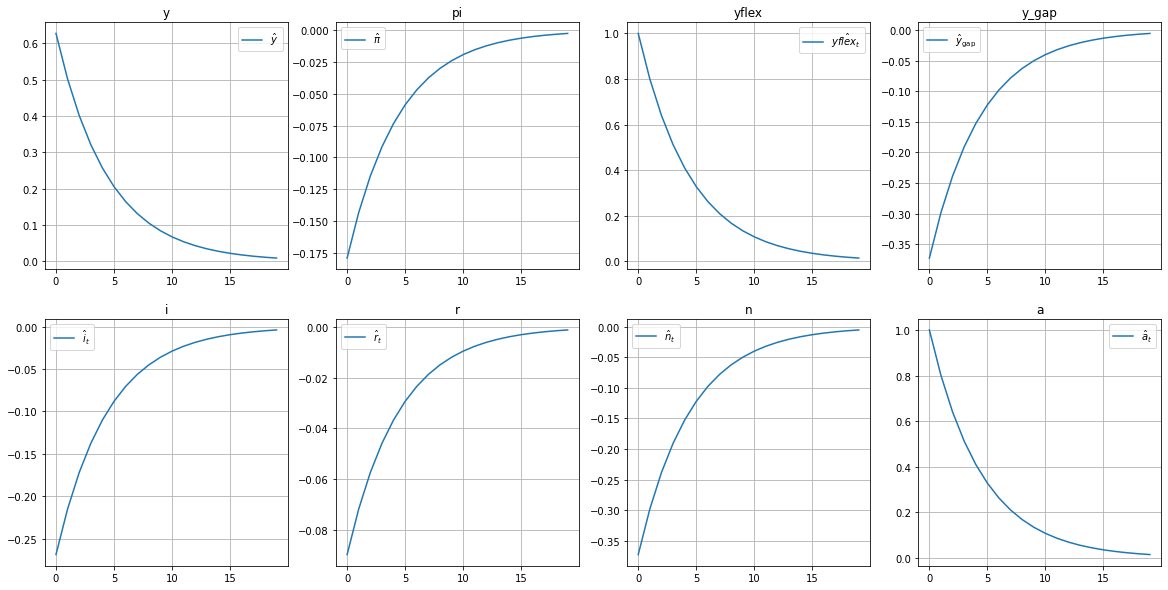

In [19]:


# Time horizon and initial conditions
T = 20
a_t = np.zeros(T)
epsilon_t = np.zeros(T)
epsilon_t[0] = 1  # Impulse at t=0

# Generate the autoregressive process for a_t
for t in range(0, T):
    a_t[t] = rho_a * a_t[t-1] + epsilon_t[t]

# Compute responses
y = y_hat(a_t)
yflex = y_flex(a_t)
y_gap = y - yflex
pi = pi_hat(a_t)
i = i_hat(a_t)
r = i - pi
n = y - a_t

# Plotting
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

ax[0,0].plot(y, label=r'$\hat{y}$')
ax[0,0].set_title('y')
ax[0,0].legend()
ax[0,0].grid(True)

ax[0,1].plot(pi, label=r'$\hat{\pi}$')
ax[0,1].set_title('pi')
ax[0,1].legend()
ax[0,1].grid(True)

ax[0,2].plot(yflex, label=r'$\hat{yflex}_t$')
ax[0,2].set_title('yflex')
ax[0,2].legend()
ax[0,2].grid(True)

ax[0,3].plot(y_gap, label=r'$\hat{y}_{\text{gap}}$')
ax[0,3].set_title('y_gap')
ax[0,3].legend()
ax[0,3].grid(True)


ax[1,0].plot(i, label=r'$\hat{i}_t$')
ax[1,0].set_title('i')
ax[1,0].legend()
ax[1,0].grid(True)

ax[1,1].plot(r, label=r'$\hat{r}_t$')
ax[1,1].set_title('r')
ax[1,1].legend()
ax[1,1].grid(True)

ax[1,2].plot(n, label=r'$\hat{n}_t$')
ax[1,2].set_title('n')
ax[1,2].legend()
ax[1,2].grid(True)

ax[1,3].plot(a_t, label=r'$\hat{a}_t$')
ax[1,3].set_title('a')
ax[1,3].legend()
ax[1,3].grid(True)

plt.savefig("q1b.png", dpi=300)

## Sequence Space

In [5]:
from sequence_jacobian import simple, create_model


@simple
def nkpc(pi, a, beta, kappa, gamma, varphi):
    yflex = (1+varphi)/(gamma+varphi) * a
    y = yflex + 1 / kappa * (pi - beta * pi(+1))
    y_gap = y - yflex
    n = y - a
    return y, yflex, y_gap, n

@simple
def central_bank(pi, v, phi_pi):
    i = phi_pi * pi + v
    return i

@simple
def mkt_clearing(y, i, pi, gamma):
    euler = gamma * y + i - pi(+1) - gamma * y(+1)
    r = i - pi(+1)
    c = y
    return euler, r, c


In [6]:
print(nkpc)
print(f"Inputs: {nkpc.inputs}")
print(f"Outputs: {nkpc.outputs}")

<SimpleBlock 'nkpc'>
Inputs: ['pi', 'a', 'beta', 'kappa', 'gamma', 'varphi']
Outputs: ['y', 'yflex', 'y_gap', 'n']


In [7]:
nk = create_model([nkpc, central_bank, mkt_clearing], name="NK")

print(nk)
print(f"Blocks: {nk.blocks}")

<Model 'NK'>
Blocks: [<SimpleBlock 'central_bank'>, <SimpleBlock 'nkpc'>, <SimpleBlock 'mkt_clearing'>]


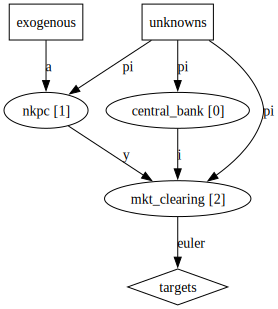

In [8]:
from sequence_jacobian.utilities.drawdag import drawdag
import os
os.environ["PATH"] += os.pathsep + '/opt/local/bin'  # Mac
# os.environ["PATH"] += os.pathsep + 'C:/Users/ygnmax/Downloads/windows_10_msbuild_Release_graphviz-11.0.0-win32/Graphviz/bin' # Win

unknowns = ['pi']
targets = ['euler']
inputs = ['a']

drawdag(nk, inputs, unknowns, targets, save="nk.png")

In [9]:
# initial parameters
beta = 0.99
sigma = 1
kappa = 0.1
rho_a = 0.8
phi_pi = 1.5
gamma = 1/sigma
varphi = 1
v = 0

# steady state values
calibration = {'a': 0, 'v': 0, 'y': 0, 'c': 0, 'r': 0, 'i': 0, 
               'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'kappa': kappa, 'rho_a': rho_a, 'varphi': varphi}

# solve for steady state (we know it, but running this routine helps us check for mistakes)
unknowns_ss = {'pi': 0}
targets_ss = { "euler": 0}

ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")

# checking that we are in the steady state that we expect
assert np.allclose(ss['pi'], 0)
assert np.allclose(ss['euler'], 0)

In [10]:
G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)

print(G)

<JacobianDict outputs=['pi', 'y', 'yflex', 'y_gap', 'n', 'i', 'euler', 'r', 'c'], inputs=['a']>


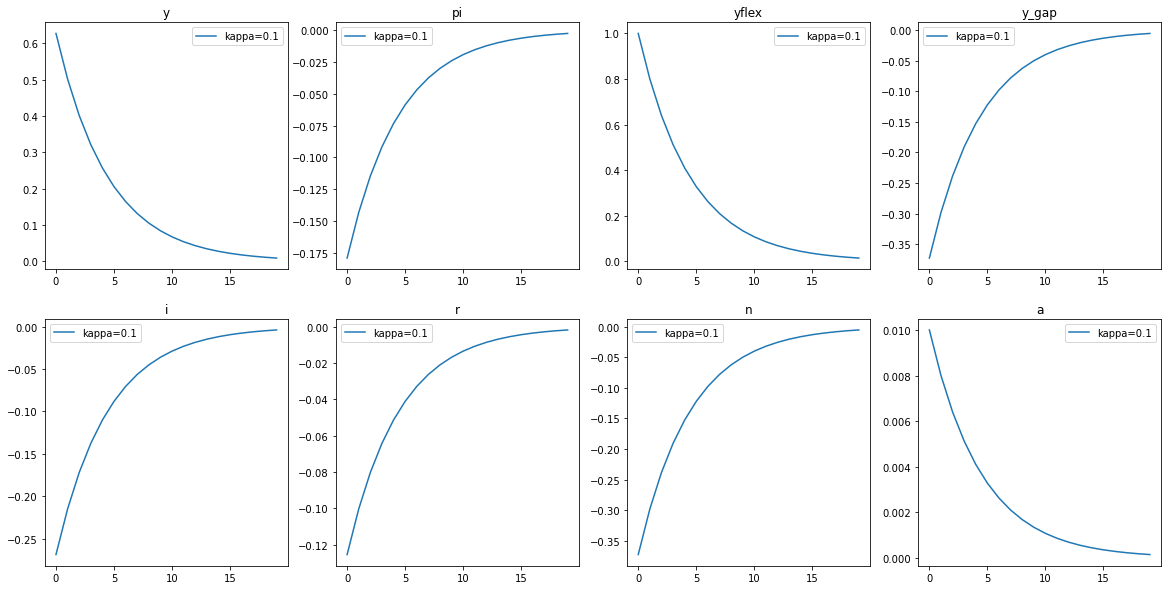

In [11]:
T, Tplot, impact, news = 300, 20, 0.01, 10
da = np.empty((T, 1))
da[:, 0] = impact * rho_a**np.arange(T)

# plot responses for shock, nominal interest rate, real interest rate, inflation, output, and employment
plotset = ['y', 'pi', 'yflex', 'y_gap', 'i', 'r', 'n', 'a']
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, var in enumerate(plotset):
    if var == 'a':
        irf1 = da[:Tplot]
    else:
        irf1 = 100 * (G[var]['a'] @ da)[:Tplot]
    axi = ax[i // 4, i % 4]
    axi.plot(irf1, label="kappa=0.1")

    axi.set_title(f"{var}")
    axi.xlabel = "quarters"
    axi.ylabel = "% deviation"
    axi.legend()
    
plt.savefig("q1d.png", dpi=300)

## Nonlinear

The nonlinear equation system is:
$$
\begin{eqnarray*}
\frac{W_t}{P_t} &=& \frac{\chi N_t^{\varphi}}{C_t^{-\gamma}} \\
1 &=& \beta E_t\left\{Q_t \frac{P_t}{P_{t+1}} \frac{C_{t+1}^{-\gamma}}{C_t^{-\gamma}}\right\} \\
B_t &=& \frac{F_{1t}}{F_{2t}} \\
F_{1, t} &=& (1+\mu) Y_t \frac{W_t}{P_t A_t}+\theta \beta\left(\frac{c_{t+1}}{c_t}\right)^{-\gamma} \Pi_{t+1}^\epsilon F_{1, t+1} \\
F_{2, t} &=& Y_t+\theta \beta\left(\frac{C_{t+1}}{C_t}\right)^{-\gamma} \Pi_{t+1}^{\epsilon-1} F_{2, t+1}   \\
1 &=&(1-\theta) B_t^{1-\epsilon}+\theta \Pi^{\epsilon-1} \\
Y_t &=& C_t \\
Y_t &=& A_t N_t \\
Q_t &=& \beta^{-1}\left(\frac{P_t}{P_{t-1}}\right)^{\phi_\pi} e^{V_t}    
\end{eqnarray*}
$$

In [12]:
from sequence_jacobian import simple, create_model

@simple
def market_clear(gamma, beta, theta, epsil, w, y, p, q, a, n, f1, f2):
    mu = 1/(epsil - 1)
    pi = p/p(-1)
    r = q/(p(+1)/p)
    c = y
    resf1 = (1+mu)*y*w/(p * a) + beta*theta*(pi(+1)**epsil)*(c(+1)**(-gamma))*(c**(gamma))*f1(+1)-f1
    resf2 = y + beta*theta*(pi(+1))**(epsil-1)*((c(+1))**(-gamma))*(c**gamma)*f2(+1)-f2
    b = f1/f2 
    pstar = b*p
    euler = beta * c(+1)**(-gamma) * q * (p / p(+1)) - c**(-gamma)
    res = (1-theta) * b**(1-epsil) + theta*(pi**(epsil-1))-1
    return euler, res, resf1, resf2, r, c, b, pstar, pi

@simple
def monetary_policy(beta, phi_pi, v, p):
    pi = p/p(-1)
    q = 1/beta*(pi**phi_pi)*(2.7182818284590452353602874)**v
    return q

@simple
def wage(chi, varphi, gamma, y, n, p, a):
    c = y
    w = (chi * n**varphi * c**gamma) * p
    mc = (p*a)/w
    return w, mc


@simple
def production(a, n, varphi, gamma):
    yflex = (1+varphi)/(gamma+varphi) * a
    y = a * n
    y_gap = y - yflex
    return y, yflex, y_gap
    

In [13]:
nlnk = create_model([production, wage, monetary_policy, market_clear], name="NLNK")

print(nlnk)
print(f"Blocks: {nlnk.blocks}")

<Model 'NLNK'>
Blocks: [<SimpleBlock 'monetary_policy'>, <SimpleBlock 'production'>, <SimpleBlock 'wage'>, <SimpleBlock 'market_clear'>]


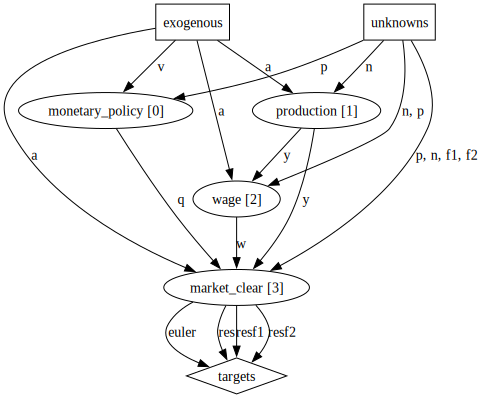

In [14]:
from sequence_jacobian.utilities.drawdag import drawdag
import os
os.environ["PATH"] += os.pathsep + '/opt/local/bin'  # Mac
# os.environ["PATH"] += os.pathsep + 'C:/Users/ygnmax/Downloads/windows_10_msbuild_Release_graphviz-11.0.0-win32/Graphviz/bin'  # Win

unknowns = ['p', 'n', 'f1', 'f2']
targets = ['euler', 'res', 'resf1', 'resf2']
inputs = ['a', 'v']

drawdag(nlnk, inputs, unknowns, targets, save="nlnk.png")

In [15]:
# initial parameters
beta = 0.99
sigma = 1
kappa = 0.1
rho_a = 0.8
sigma_a = 0.01
phi_pi = 1.5
gamma = 1/sigma
varphi = 1
v = 0
chi = 1
epsil = 10
phi_y = 0
mu=1/(epsil - 1)
theta = 0.5
# steady state values
calibration = {'a': 1, 'v': 0, 'yflex': 1, 'y': np.sqrt(1/(1+mu)), 'c': np.sqrt(1/(1+mu)), 'pstar': 1, 
               'w': 1/(1+mu), 'q': 1/beta, 'mu': mu, 'varphi': varphi, 'chi':chi,
               'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'kappa': kappa, 'epsil':epsil}

# solve for steady state (we know it, but running this routine helps us check for mistakes)
unknowns_ss = {'p': 1, 'n': np.sqrt(1/(1+mu)), 
               'f1':np.sqrt(1/(1+mu))/(1-(beta*theta)), 
               'f2': np.sqrt(1/(1+mu))/(1-(beta*theta))}
targets_ss = { "euler": 0., "res": 0., "resf1": 0., "resf2": 0.}

In [16]:
theta_list =[0.0001, 0.25, 0.5, 0.75, 0.9999]
ss_list = []
G_list = []

for theta in theta_list:
    calibration_tmp = calibration.copy()
    calibration_tmp['theta'] = theta
    unknowns_ss['f1'] = np.sqrt(1/(1+mu))/(1-(beta*theta)) 
    unknowns_ss['f2'] = np.sqrt(1/(1+mu))/(1-(beta*theta))

    # calculate new steady state
    ss_tmp = nlnk.solve_steady_state(calibration_tmp, unknowns_ss, targets_ss, solver="broyden_custom")
    
    # calculate new Jacobian
    G_tmp = nlnk.solve_jacobian(ss_tmp, unknowns, targets, inputs, T=300)
    
    ss_list.append(ss_tmp)
    G_list.append(G_tmp)

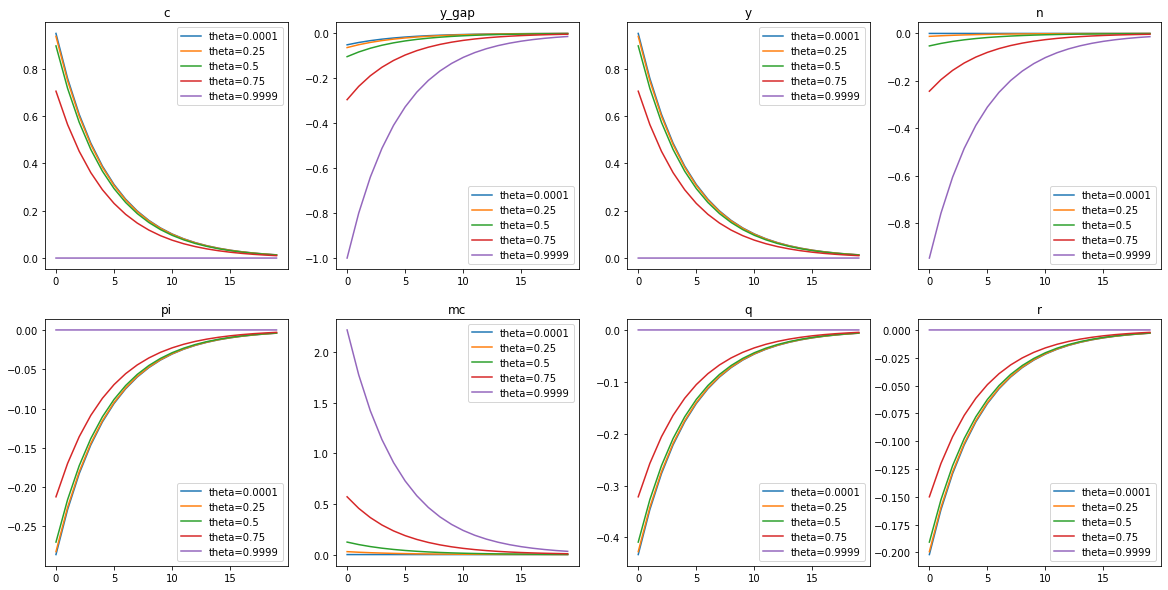

In [17]:
T, Tplot, impact, news = 300, 20, 0.01, 10
da = np.empty((T, 1))
da[:, 0] = impact * rho_a**np.arange(T)

# plot responses for shock, nominal interest rate, real interest rate, inflation, output, and employment
plotset = ['c', 'y_gap', 'y', 'n', 'pi', 'mc', 'q', 'r']
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, var in enumerate(plotset):
    if var == 'a':
        irf1 = da[:Tplot]
        irf2 = da[:Tplot]
        irf3 = da[:Tplot]
        irf4 = da[:Tplot]
        irf5 = da[:Tplot]
    else:
        irf1 = 100 * (G_list[0][var]['a'] @ da)[:Tplot]
        irf2 = 100 * (G_list[1][var]['a'] @ da)[:Tplot]
        irf3 = 100 * (G_list[2][var]['a'] @ da)[:Tplot]
        irf4 = 100 * (G_list[3][var]['a'] @ da)[:Tplot]
        irf5 = 100 * (G_list[4][var]['a'] @ da)[:Tplot]
        
    axi = ax[i // 4, i % 4]
    axi.plot(irf1, label="theta=0.0001")
    axi.plot(irf2, label="theta=0.25")
    axi.plot(irf3, label="theta=0.5")
    axi.plot(irf4, label="theta=0.75")
    axi.plot(irf5, label="theta=0.9999")
    
    axi.set_title(f"{var}")
    axi.xlabel = "quarters"
    axi.ylabel = "% deviation"
    axi.legend()

plt.savefig("q2g.png", dpi=300)